# COVID19_analysis

In [ ]:
# DB instance identifier: database-1
# username: thomas
# password: thomas1234
# host: database-1.cyrwztrhdlnq.us-east-1.rds.amazonaws.com
# port: 3306

In [1]:
!pip install PyMySQL
!pip install wget
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=cbffad0ccd9a9c960956fed9b4609bcfdbe91ee7ca21e9e35fc7c69dc73ebd41
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 5.3 MB/s 
     |████████████████████████████████| 6.3 MB 37.3 MB/s 
     |████████████████████████████████| 16.7 MB 38.3 MB/s 


In [2]:
!pip install github-clone
!ghclone https://github.com/StellarCN/scp_zh/tree/master/fonts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Cloning into 'fonts'...
done.


In [3]:
import pymysql
import pandas as pd
import wget
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.font_manager import FontProperties
from google.colab import drive
drive.mount('/content/gdrive')
!cp -r ./gdrive/MyDrive/Application_with_DBMS_and_AWS/* .

Mounted at /content/gdrive


In [4]:
def execute_sql(cursor, db, sql):
  cursor.execute(sql)
  db.commit()

In [5]:
def connect_and_get_cursor_with_utf8_encoding():
  db = pymysql.connect(host='database-1.cyrwztrhdlnq.us-east-1.rds.amazonaws.com', user='thomas', password='thomas1234', port=3306, local_infile=True)
  cursor = db.cursor()
  cursor.execute('SELECT VERSION()')
  data = cursor.fetchone()
  print ("Database version : %s " % data)
  sql = '''DROP DATABASE IF EXISTS database_1'''
  execute_sql(cursor, db, sql)
  sql = '''CREATE DATABASE IF NOT EXISTS database_1'''
  execute_sql(cursor, db, sql)
  sql = '''USE database_1'''
  execute_sql(cursor, db, sql)
  return db, cursor

In [6]:
db, cursor = connect_and_get_cursor_with_utf8_encoding()

Database version : 8.0.28 


# 1. CSSE

In [7]:
def load_and_create_CSSE(cursor, db):
  URL = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
  response = wget.download(URL, "owid-covid-data.csv")

  sql = '''DROP TABLE IF EXISTS `owid-covid-data`'''
  execute_sql(cursor, db, sql)
  
  sql = '''
  CREATE TABLE IF NOT EXISTS `owid-covid-data`(
    `iso_code` TEXT NOT NULL,
    `continent` TEXT NOT NULL,
    `location` TEXT NOT NULL,
    `date` Date NOT NULL,
    `total_cases` integer,
    `new_cases` integer,
    `new_cases_smoothed` double precision,
    `total_deaths` integer,
    `new_deaths` integer,
    `new_deaths_smoothed` double precision,
    `total_cases_per_million` double precision,
    `new_cases_per_million` double precision,
    `new_cases_smoothed_per_million` double precision,
    `total_deaths_per_million` double precision,
    `new_deaths_per_million` double precision,
    `new_deaths_smoothed_per_million` double precision,
    `reproduction_rate` double precision,
    `icu_patients` double precision,
    `icu_patients_per_million` double precision,
    `hosp_patients` double precision,
    `hosp_patients_per_million` double precision,
    `weekly_icu_admissions` double precision,
    `weekly_icu_admissions_per_million` double precision,
    `weekly_hosp_admissions` double precision,
    `weekly_hosp_admissions_per_million` double precision,
    `total_tests` double precision,
    `new_tests` double precision,
    `total_tests_per_thousand` double precision,
    `new_tests_per_thousand` double precision,
    `new_tests_smoothed` double precision,
    `new_tests_smoothed_per_thousand` double precision,
    `positive_rate` double precision,
    `tests_per_case` double precision,
    `tests_units` double precision,
    `total_vaccinations` double precision,
    `people_vaccinated` double precision,
    `people_fully_vaccinated` double precision,
    `total_boosters` double precision,
    `new_vaccinations` double precision,
    `new_vaccinations_smoothed` double precision,
    `total_vaccinations_per_hundred` double precision,
    `people_vaccinated_per_hundred` double precision,
    `people_fully_vaccinated_per_hundred` double precision,
    `total_boosters_per_hundred` double precision,
    `new_vaccinations_smoothed_per_million` double precision,
    `new_people_vaccinated_smoothed` double precision,
    `new_people_vaccinated_smoothed_per_hundred` double precision,
    `stringency_index` double precision,
    `population` double precision,
    `population_density` double precision,
    `median_age` double precision,
    `aged_65_older` double precision,
    `aged_70_older` double precision,
    `gdp_per_capita` double precision,
    `extreme_poverty` double precision,
    `cardiovasc_death_rate` double precision,
    `diabetes_prevalence` double precision,
    `female_smokers` double precision,
    `male_smokers` double precision,
    `handwashing_facilities` double precision,
    `hospital_beds_per_thousand` double precision,
    `life_expectancy` double precision,
    `human_development_index` double precision,
    `excess_mortality_cumulative_absolute` double precision,
    `excess_mortality_cumulative` double precision,
    `excess_mortality` double precision,
    `excess_mortality_cumulative_per_million` double precision
  );
  '''
  execute_sql(cursor, db, sql)

  sql = '''
  LOAD DATA LOCAL INFILE './owid-covid-data.csv'
  INTO TABLE `owid-covid-data`
  FIELDS TERMINATED BY ','
  IGNORE 1 ROWS;
  '''
  execute_sql(cursor, db, sql)

In [8]:
def normalize_CSSE(cursor, db):
  sql = '''DROP TABLE IF EXISTS `iso_to_country`'''
  execute_sql(cursor, db, sql)

  sql = '''
  CREATE TABLE IF NOT EXISTS `iso_to_country`(
    `iso_code` TEXT NOT NULL,
    `continent` TEXT NOT NULL,
    `location` TEXT NOT NULL
  );
  '''
  execute_sql(cursor, db, sql)
  sql = '''
  INSERT INTO `iso_to_country` (`iso_code`, `continent`, `location`)
  SELECT distinct(`iso_code`), `continent`, `location` FROM `owid-covid-data`
  '''
  execute_sql(cursor, db, sql)
  sql = '''
  ALTER TABLE `owid-covid-data`
  DROP COLUMN `continent`,
  DROP COLUMN `location`;
  '''
  execute_sql(cursor, db, sql)

In [9]:
def get_CSSE_record_cnt(cursor):
  sql = '''
  SELECT count(*) FROM `owid-covid-data`
  '''
  cursor.execute(sql)
  result=cursor.fetchall()
  print('CSSE record count:')
  for row in result:
      print(row)

In [10]:
def get_CSSE_examples(cursor):
  sql = '''
  SELECT * FROM `owid-covid-data`
  LIMIT 10
  '''
  cursor.execute(sql)
  result=cursor.fetchall()
  print('CSSE examples')
  for row in result:
      print(row)

In [11]:
def plot_CSSE(cursor, sql, title, xlabel, ylabel):
  cursor.execute(sql)
  result=cursor.fetchall()
  x = [row[0] for row in result]
  y = [row[1] for row in result]

  plt.rcParams['figure.figsize'] = [16, 8]
  plt.plot(x, y)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()
  plt.clf()
  plt.cla()
  plt.close()

In [12]:
def plot_global_daily_confirmed_cases(cursor):
  sql = '''
  SELECT date, sum(new_cases) FROM `owid-covid-data`
  GROUP BY date
  ORDER BY date
  '''
  plot_CSSE(cursor, sql, 'Global Daily New Confirmed Cases', 'Date', 'Confirmed Cases')

In [13]:
def plot_global_daily_deaths(cursor):
  sql = '''
  SELECT date, sum(new_deaths) FROM `owid-covid-data`
  GROUP BY date
  ORDER BY date
  '''
  plot_CSSE(cursor, sql, 'Global Daily New Deaths', 'Date', 'Deaths')

In [14]:
def plot_taiwan_daily_confirmed_cases(cursor):
  sql = '''
  SELECT date, sum(new_cases) FROM `owid-covid-data`
  WHERE iso_code='TWN'
  GROUP BY date
  ORDER BY date
  '''
  plot_CSSE(cursor, sql, 'Taiwan Daily New Confirmed Cases', 'Date', 'Confirmed Cases')

In [15]:
def plot_taiwan_daily_deaths(cursor):
  sql = '''
  SELECT date, sum(new_deaths) FROM `owid-covid-data`
  WHERE iso_code='TWN'
  GROUP BY date
  ORDER BY date
  '''
  plot_CSSE(cursor, sql, 'Taiwan Daily New Deaths', 'Date', 'Deaths')

In [16]:
load_and_create_CSSE(cursor, db)
normalize_CSSE(cursor, db)
get_CSSE_record_cnt(cursor)
get_CSSE_examples(cursor)

CSSE record count:
(195844,)
CSSE examples
('AFG', datetime.date(2020, 2, 24), 5, 5, 0.0, 0, 0, 0.0, 0.126, 0.126, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.33, 39835428.0, 54.422, 18.6, 2.581, 1.337, 1803.987, 0.0, 597.029, 9.59, 0.0, 0.0, 37.746, 0.5, 64.83, 0.511, 0.0, 0.0, 0.0, 0.0)
('AFG', datetime.date(2020, 2, 25), 5, 0, 0.0, 0, 0, 0.0, 0.126, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.33, 39835428.0, 54.422, 18.6, 2.581, 1.337, 1803.987, 0.0, 597.029, 9.59, 0.0, 0.0, 37.746, 0.5, 64.83, 0.511, 0.0, 0.0, 0.0, 0.0)
('AFG', datetime.date(2020, 2, 26), 5, 0, 0.0, 0, 0, 0.0, 0.126, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

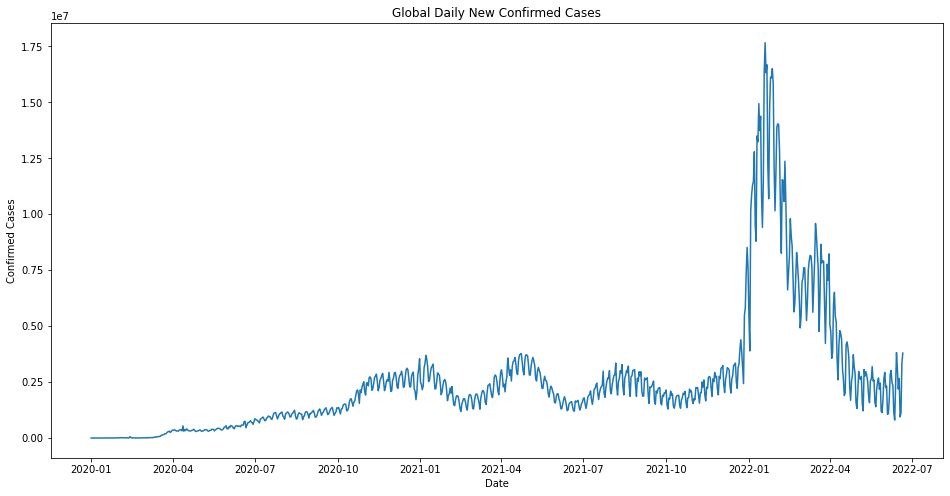

In [17]:
plot_global_daily_confirmed_cases(cursor)

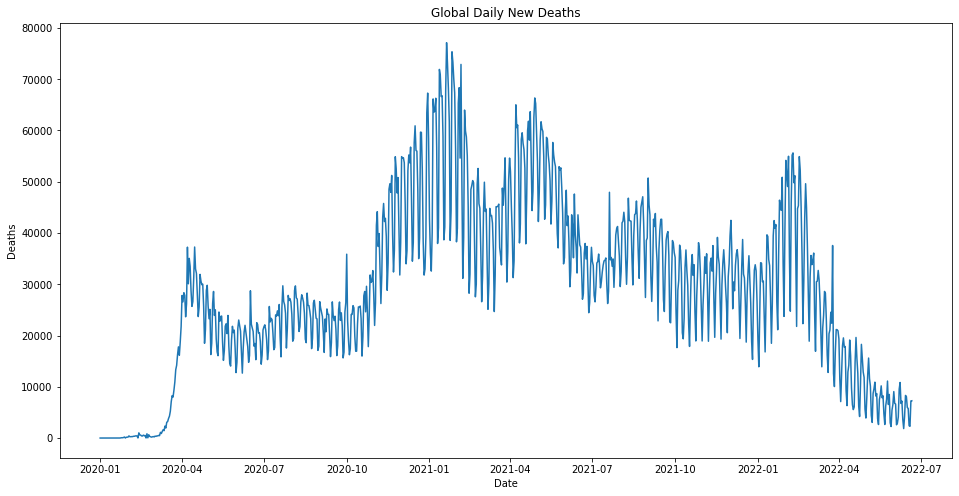

In [18]:
plot_global_daily_deaths(cursor)

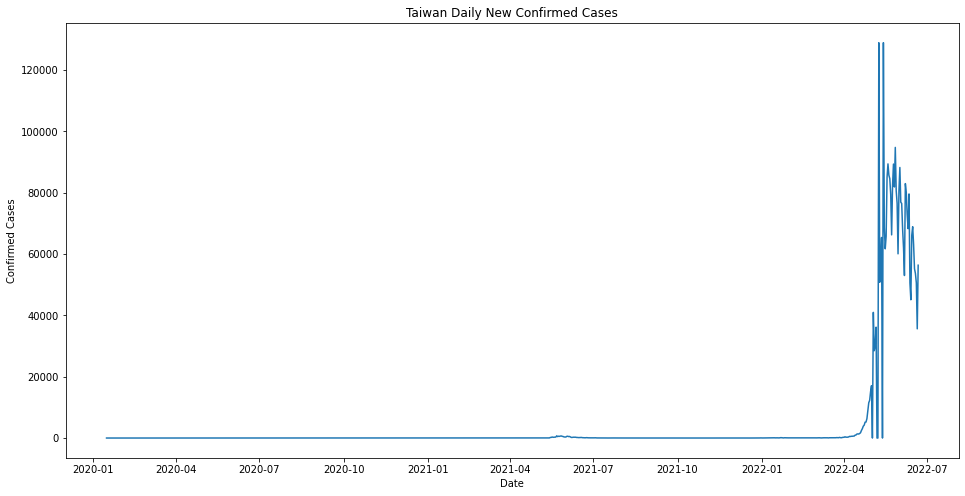

In [19]:
plot_taiwan_daily_confirmed_cases(cursor)

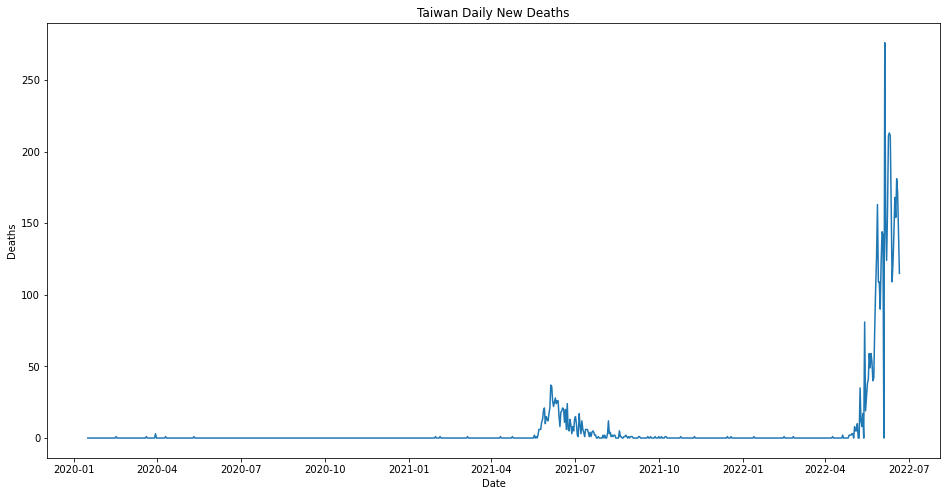

In [20]:
plot_taiwan_daily_deaths(cursor)

# 2. Global Seven Days Moving Average

In [21]:
def connect_and_get_cursor_with_big5_encoding():
  db = pymysql.connect(host='database-1.cyrwztrhdlnq.us-east-1.rds.amazonaws.com', user='thomas', password='thomas1234', port=3306, charset='big5', local_infile=True)
  cursor = db.cursor()
  sql = '''DROP DATABASE IF EXISTS database_2'''
  execute_sql(cursor, db, sql)
  sql = '''CREATE DATABASE IF NOT EXISTS database_2'''
  execute_sql(cursor, db, sql)
  sql = '''USE database_2'''
  execute_sql(cursor, db, sql)
  return db, cursor

In [22]:
def load_and_create_world_covid19():
  URL = "https://covid-19.nchc.org.tw/api/download/owl_world_v2_2022-06-21.csv"
  response = wget.download(URL, "world_covid19.csv")

  sql = '''DROP TABLE IF EXISTS `world_covid19`'''
  execute_sql(cursor, db, sql)

  sql = '''
  CREATE TABLE IF NOT EXISTS `world_covid19`(
    `id` integer NOT NULL,
    `iso_code` TEXT NOT NULL,
    `洲名` TEXT,
    `國家` TEXT,
    `日期` Date NOT NULL,
    `總確診數` integer NOT NULL,
    `新增確診數` integer,
    `七天移動平均新增確診數` double precision,
    `總確診數/每百萬人` double precision,
    `新增確診數/每百萬人` double precision,
    `七天移動平均新增確診數/每百萬人` double precision,
    `總人口數` integer,
    `新聞稿發佈新增確診數` TEXT
  );
  '''
  execute_sql(cursor, db, sql)

  sql = '''SET NAMES big5'''
  execute_sql(cursor, db, sql)

  sql = '''
  LOAD DATA LOCAL INFILE './world_covid19.csv'
  INTO TABLE `world_covid19`
  CHARACTER SET big5
  FIELDS TERMINATED BY ','
  LINES TERMINATED BY '\n'
  IGNORE 1 ROWS;
  '''
  execute_sql(cursor, db, sql)

In [23]:
def get_world_covid19_record_cnt(cursor):
  sql = '''
  SELECT count(*) FROM `world_covid19`
  '''
  cursor.execute(sql)
  result=cursor.fetchall()
  print('world_covid19 record count:')
  for row in result:
      print(row)

In [24]:
def get_world_covid19_examples(cursor):
  sql = '''
  SELECT * FROM `world_covid19`
  LIMIT 10
  '''
  cursor.execute(sql)
  result=cursor.fetchall()
  print('world_covid19 examples')
  for row in result:
      print(row)

In [25]:
def plot_world_covid19_moving_avg_confirmed_cases(cursor):
  sql = '''
  SELECT `國家`, `七天移動平均新增確診數` FROM `world_covid19`
  ORDER BY `七天移動平均新增確診數` DESC
  '''
  cursor.execute(sql)
  result=cursor.fetchall()
  country = [row[0] for row in result]
  seven_days_avg = [row[1] for row in result]

  path = './fonts/SimHei.ttf'
  tick_font = FontProperties(fname=path)
  plt.rcParams['figure.figsize'] = [32, 16]
  plt.bar(country[1:31], seven_days_avg[1:31])
  plt.title('Global Seven Days Average Confirmed Cases', fontsize=16)
  plt.xticks(fontproperties = tick_font, fontsize=16)
  plt.xlabel('Country', fontsize=16)
  plt.ylabel('Seven Days Average')
  plt.show()
  plt.clf()
  plt.cla()
  plt.close()

In [26]:
db, cursor = connect_and_get_cursor_with_big5_encoding()

In [27]:
load_and_create_world_covid19()

In [28]:
get_world_covid19_record_cnt(cursor)

world_covid19 record count:
(226,)


In [29]:
get_world_covid19_examples(cursor)

world_covid19 examples
(1, 'ZWE', '非洲', '辛巴威', datetime.date(2022, 6, 20), 254831, 30, 96.571, 16884.98, 1.988, 6.399, 15092171, '-')
(2, 'ZMB', '非洲', '尚比亞', datetime.date(2022, 6, 20), 324344, 56, 151.571, 17142.322, 2.96, 8.011, 18920657, '-')
(40, 'ZAF', '非洲', '南非', datetime.date(2022, 6, 20), 3986892, 291, 1109.429, 66401.723, 4.847, 18.478, 60041996, '-')
(3, 'YEM', '亞洲', '葉門', datetime.date(2022, 6, 17), 11823, 1, 0.143, 387.758, 0.033, 0.005, 30490639, '-')
(54, 'WSM', '大洋洲', '薩摩亞', datetime.date(2022, 6, 16), 14497, 75, 81.857, 72432.848, 374.73, 408.991, 200144, '-')
(5, 'WLF', '大洋洲', '渥里斯及伏塔那', datetime.date(2022, 6, 20), 454, 0, 0.0, 40923.021, 0.0, 0.0, 11094, '-')
(9, 'VUT', '大洋洲', '萬那杜', datetime.date(2022, 6, 19), 10924, 67, 61.0, 34738.476, 213.061, 193.981, 314464, '-')
(6, 'VNM', '亞洲', '越南', datetime.date(2022, 6, 20), 10738161, 521, 818.857, 109384.63, 5.307, 8.341, 98168829, '-')
(12, 'VIR', '北美洲', '美屬維爾京群島', datetime.date(2022, 6, 16), 0, 0, 0.0, 0.0, 0.0, 0.0, 104

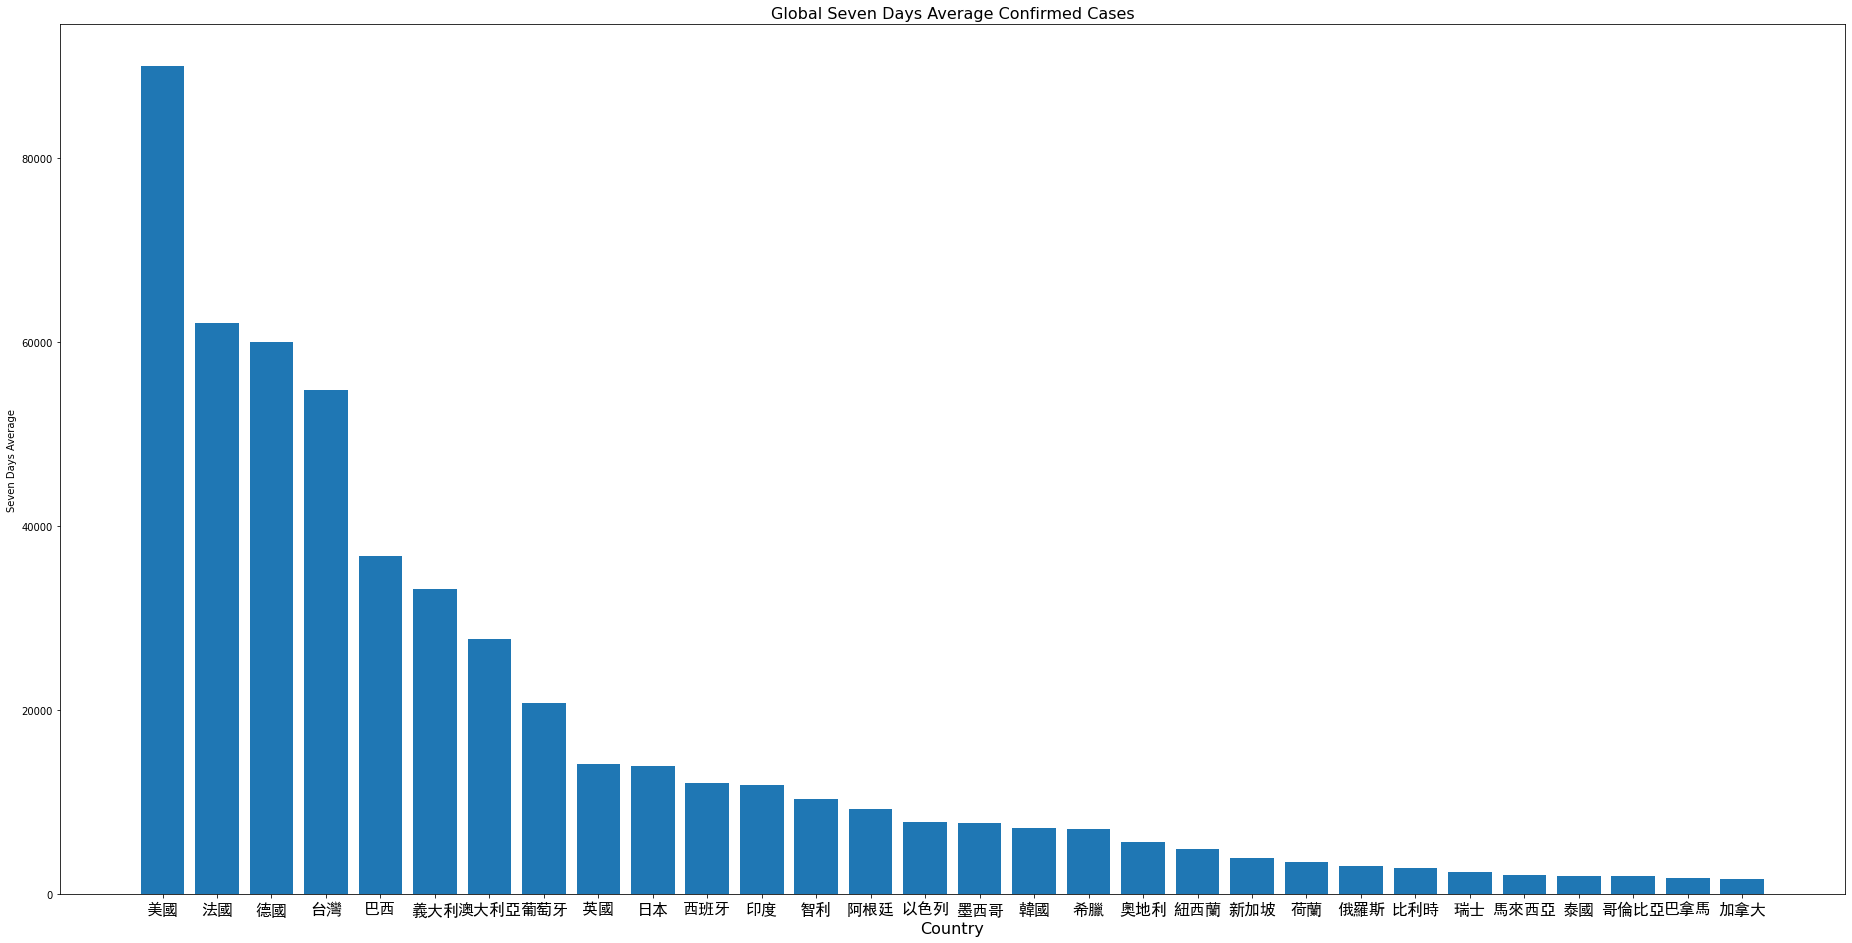

In [30]:
plot_world_covid19_moving_avg_confirmed_cases(cursor)

# 3. Taiwan Map

In [31]:
def load_and_preprocess_taiwan_shp():
  taiwan_shp = gpd.read_file('./TOWN_MOI_1100415.shp', encoding='utf-8')
  print('Before preprocess taiwan_shp')
  print(taiwan_shp.head())
  taiwan_shp = taiwan_shp.drop(taiwan_shp.columns[[0,1,4,5,6]], axis=1)
  print('After preprocess taiwan_shp')
  print(taiwan_shp.head())
  return taiwan_shp

In [32]:
def load_and_preprocess_cdc_taiwan():
  URL = "https://covid-19.nchc.org.tw/api/download/covidtable_taiwan_cdc4_1_2022-06-21.csv"
  taiwan_data = pd.read_csv(URL, encoding = 'big5')
  print('Schema before preprocess taiwan_data')
  print(taiwan_data.info(verbose = True, null_counts = False))
  print('Examples before preprocess taiwan_data')
  print(taiwan_data.head())
  taiwan_data = taiwan_data[taiwan_data['區域']=='全區']
  taiwan_data=taiwan_data.drop(taiwan_data.columns[[0,2,4]], axis=1)
  print('Schema after preprocess taiwan_data')
  print(taiwan_data.info(verbose = True, null_counts = False))
  print('Examples After preprocess taiwan_data')
  print(taiwan_data.head())
  return taiwan_data

In [33]:
def plot_taiwan_total_confirmed_cases(taiwan_data, taiwan_shp):
  taiwan_total_cases = taiwan_data.groupby('縣市別').sum()
  print('Taiwan total confirmed cases')
  print(taiwan_total_cases.head())
  left = taiwan_shp.set_index('COUNTYNAME')
  right = taiwan_total_cases
  result = left.join(right)
  result = result.fillna(0)
  print('Results after join')
  print(result.head())
  plt.rcParams['figure.figsize'] = [16, 8]
  fig, ax = plt.subplots(1, 1)
  map = result.plot(column='新增確診人數', ax=ax, legend=True)
  map.set_xlim(119, 122.5)
  map.set_ylim(21.5, 25.5)
  ax.set_title('Taiwan Total Confirmed Cases')
  ax.set_xlabel('Longitude')
  ax.set_ylabel('Latitude')

In [34]:
def plot_taiwan_latest_confirmed_cases(taiwan_data, taiwan_shp):
  latest_taiwan_data = taiwan_data[taiwan_data['個案研判日']=='2022-06-19']
  print('Taiwan latest confirmed cases (Before preprocessing)')
  print(latest_taiwan_data.head())
  latest_taiwan_data=latest_taiwan_data.drop(latest_taiwan_data.columns[[0,3]], axis=1)
  print('Taiwan latest confirmed cases (After preprocessing)')
  print(latest_taiwan_data.head())
  left = taiwan_shp.set_index('COUNTYNAME')
  right = latest_taiwan_data.set_index('縣市別')
  result = left.join(right)
  result = result.fillna(0)
  print('Results after join')
  print(result.head())
  plt.rcParams['figure.figsize'] = [16, 8]
  fig, ax = plt.subplots(1, 1)
  map = result.plot(column='新增確診人數', ax=ax, legend=True)
  map.set_xlim(119, 122.5)
  map.set_ylim(21.5, 25.5)
  ax.set_title('Taiwan Latest Confirmed Cases')
  ax.set_xlabel('Longitude')
  ax.set_ylabel('Latitude')

In [35]:
taiwan_shp = load_and_preprocess_taiwan_shp()
taiwan_data = load_and_preprocess_cdc_taiwan()

Before preprocess taiwan_shp
  TOWNID  TOWNCODE COUNTYNAME TOWNNAME             TOWNENG COUNTYID  \
0    V02  10014020        臺東縣      成功鎮  Chenggong Township        V   
1    T21  10013210        屏東縣      佳冬鄉    Jiadong Township        T   
2    P13  10009130        雲林縣      麥寮鄉    Mailiao Township        P   
3    V11  10014110        臺東縣      綠島鄉      Ludao Township        V   
4    V16  10014160        臺東縣      蘭嶼鄉      Lanyu Township        V   

  COUNTYCODE                                           geometry  
0      10014  POLYGON ((121.40982 23.21369, 121.40984 23.213...  
1      10013  POLYGON ((120.54846 22.46067, 120.54853 22.460...  
2      10009  POLYGON ((120.30198 23.81625, 120.30197 23.815...  
3      10014  MULTIPOLYGON (((121.49155 22.67746, 121.49185 ...  
4      10014  MULTIPOLYGON (((121.61180 21.94290, 121.61133 ...  
After preprocess taiwan_shp
  COUNTYNAME TOWNNAME                                           geometry
0        臺東縣      成功鎮  POLYGON ((121.40982 23.2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: null_counts is deprecated. Use show_counts instead
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: null_counts is deprecated. Use show_counts instead
  # This is added back by InteractiveShellApp.init_path()


Taiwan total confirmed cases
     新增確診人數    累計確診人數
縣市別                  
南投縣   46883    881635
台中市  360446   7496544
台北市  342415  11522891
台南市  213678   4336659
台東縣   27085    593340
Results after join
    TOWNNAME                                           geometry   新增確診人數  \
南投縣      南投市  POLYGON ((120.73447 23.94926, 120.73412 23.949...  46883.0   
南投縣      埔里鎮  POLYGON ((120.94366 24.05304, 120.94365 24.052...  46883.0   
南投縣      草屯鎮  POLYGON ((120.83477 23.97048, 120.83476 23.970...  46883.0   
南投縣      竹山鎮  POLYGON ((120.76394 23.81695, 120.76389 23.816...  46883.0   
南投縣      集集鎮  POLYGON ((120.84207 23.85537, 120.84202 23.855...  46883.0   

       累計確診人數  
南投縣  881635.0  
南投縣  881635.0  
南投縣  881635.0  
南投縣  881635.0  
南投縣  881635.0  


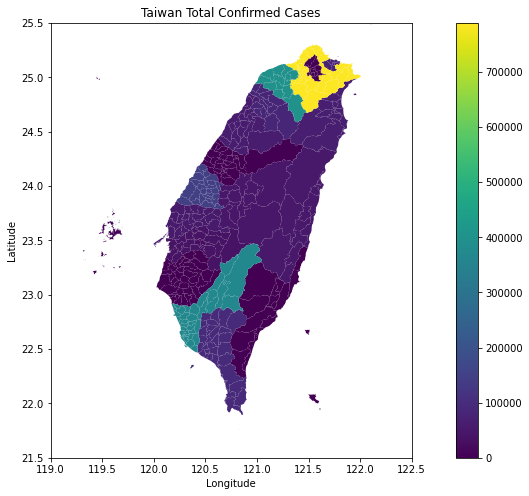

In [36]:
plot_taiwan_total_confirmed_cases(taiwan_data, taiwan_shp)

Taiwan latest confirmed cases (Before preprocessing)
         個案研判日  縣市別  新增確診人數  累計確診人數
0   2022-06-19  南投縣     886   46883
14  2022-06-19  台中市    5312  360446
44  2022-06-19  台北市    2296  342415
57  2022-06-19  台南市    3123  213678
95  2022-06-19  台東縣     307   27085
Taiwan latest confirmed cases (After preprocessing)
    縣市別  新增確診人數
0   南投縣     886
14  台中市    5312
44  台北市    2296
57  台南市    3123
95  台東縣     307
Results after join
    TOWNNAME                                           geometry  新增確診人數
南投縣      南投市  POLYGON ((120.73447 23.94926, 120.73412 23.949...   886.0
南投縣      埔里鎮  POLYGON ((120.94366 24.05304, 120.94365 24.052...   886.0
南投縣      草屯鎮  POLYGON ((120.83477 23.97048, 120.83476 23.970...   886.0
南投縣      竹山鎮  POLYGON ((120.76394 23.81695, 120.76389 23.816...   886.0
南投縣      集集鎮  POLYGON ((120.84207 23.85537, 120.84202 23.855...   886.0


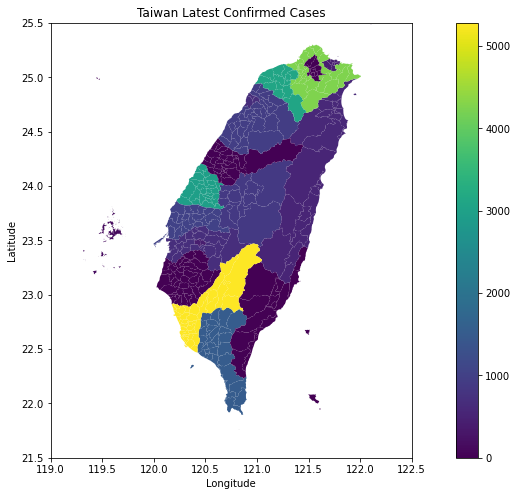

In [37]:
plot_taiwan_latest_confirmed_cases(taiwan_data, taiwan_shp)

# 4. World Map

In [38]:
def load_and_preprocess_world_shp():
  world_shp = gpd.read_file('./all_countries.shp', encoding='utf8')
  print('Before preprocess world_shp')
  print(world_shp.head())
  world_shp = world_shp[['iso_a3','geometry']]
  print('After preprocess world_shp')
  print(world_shp.head())
  return world_shp

In [39]:
def load_and_preprocess_world_data():
  URL = "https://covid-19.nchc.org.tw/api/download/owl_world_v2_2022-06-21.csv"
  world_data = pd.read_csv(URL, encoding = 'big5')
  print('Schema before preprocess world_data')
  print(world_data.info(verbose = True, null_counts = False))
  print('Examples before preprocess world_data')
  print(world_data.head())
  world_data = world_data[['iso_code', '總確診數','七天移動平均新增確診數']]
  print('Schema before preprocess world_data')
  print(world_data.info(verbose = True, null_counts = False))
  print('Examples before preprocess world_data')
  print(world_data.head())
  return world_data

In [40]:
def plot_world_total_confirmed_cases(world_data, world_shp):
  left = world_shp.set_index('iso_a3')
  right = world_data.set_index('iso_code')
  result = left.join(right)
  plt.rcParams['figure.figsize'] = [16, 6]
  fig, ax = plt.subplots(1, 1)
  map = result.plot(column='總確診數', ax=ax, legend=True)
  ax.set_title('Global Total Confirmed Cases')
  ax.set_xlabel('Longitude')
  ax.set_ylabel('Latitude')

In [41]:
def plot_world_moving_avg_confirmed_cases(world_data, world_shp):
  left = world_shp.set_index('iso_a3')
  right = world_data.set_index('iso_code')
  result = left.join(right)
  plt.rcParams['figure.figsize'] = [16, 6]
  fig, ax = plt.subplots(1, 1)
  map = result.plot(column='七天移動平均新增確診數', ax=ax, legend=True)
  ax.set_title('Global Seven Days Moving Average Confirmed Cases')
  ax.set_xlabel('Longitude')
  ax.set_ylabel('Latitude')

In [42]:
world_shp = load_and_preprocess_world_shp()
world_data = load_and_preprocess_world_data()

Before preprocess world_shp
  ADM0_A3 abbrev      continent                    formal_nam iso_a2 iso_a3  \
0     ABW  Aruba  North America                         Aruba     AW    ABW   
1     AFG   Afg.           Asia  Islamic State of Afghanistan     AF    AFG   
2     AGO   Ang.         Africa   People's Republic of Angola     AO    AGO   
3     AIA   Ang.  North America                          None     AI    AIA   
4     ALB   Alb.         Europe           Republic of Albania     AL    ALB   

   iso_n3    iso_short         name    name_sort  ...  \
0   533.0        Aruba        Aruba        Aruba  ...   
1     4.0  Afghanistan  Afghanistan  Afghanistan  ...   
2    24.0       Angola       Angola       Angola  ...   
3   660.0     Anguilla     Anguilla     Anguilla  ...   
4     8.0      Albania      Albania      Albania  ...   

                      un_fr  un_n3 un_region       un_ru       un_subregi  \
0                      None  533.0  Americas        None        Caribbean   


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: null_counts is deprecated. Use show_counts instead
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: null_counts is deprecated. Use show_counts instead
  # Remove the CWD from sys.path while we load stuff.


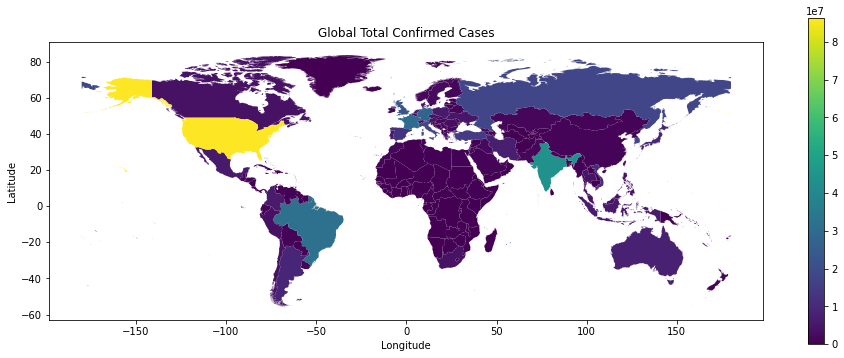

In [43]:
plot_world_total_confirmed_cases(world_data, world_shp)

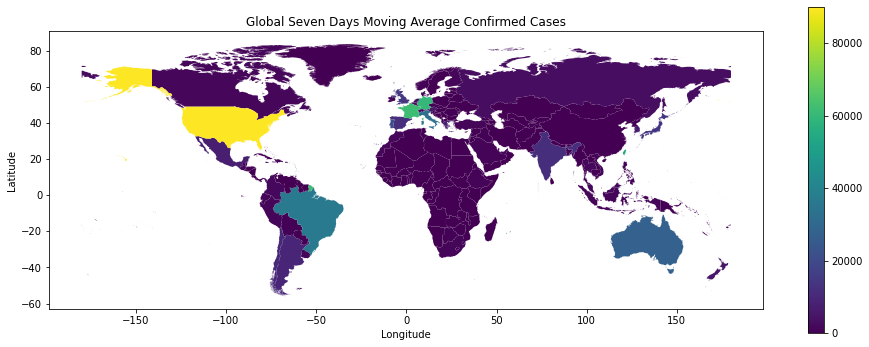

In [44]:
plot_world_moving_avg_confirmed_cases(world_data, world_shp)